In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import time
import random
import gc


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/spam-emails/spam.csv
/kaggle/input/slang-txt/Slang Text.csv


In [ ]:
%pip install -q matplotlib scikit-learn contractions nltk spacy transformers torch sacremoses

Note: you may need to restart the kernel to use updated packages.


In [ ]:
!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.7 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


# Data

Dataset is taken from next kaggle dataset, [link](https://www.kaggle.com/datasets/abdallahwagih/spam-emails/data)

## Download dataset

In [ ]:
df = pd.read_csv('/kaggle/input/spam-emails/spam.csv')
df

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


## Simple EDA

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [6]:
df.describe()

,Category,Message
count,5572,5572
unique,2,5157
top,ham,"Sorry, I'll call later"
freq,4825,30


In [7]:
df["Category"].value_counts()

Category
ham     4825
spam     747
Name: count, dtype: int64

In [8]:
df["Category"].value_counts(normalize=True)

Category
ham     0.865937
spam    0.134063
Name: proportion, dtype: float64

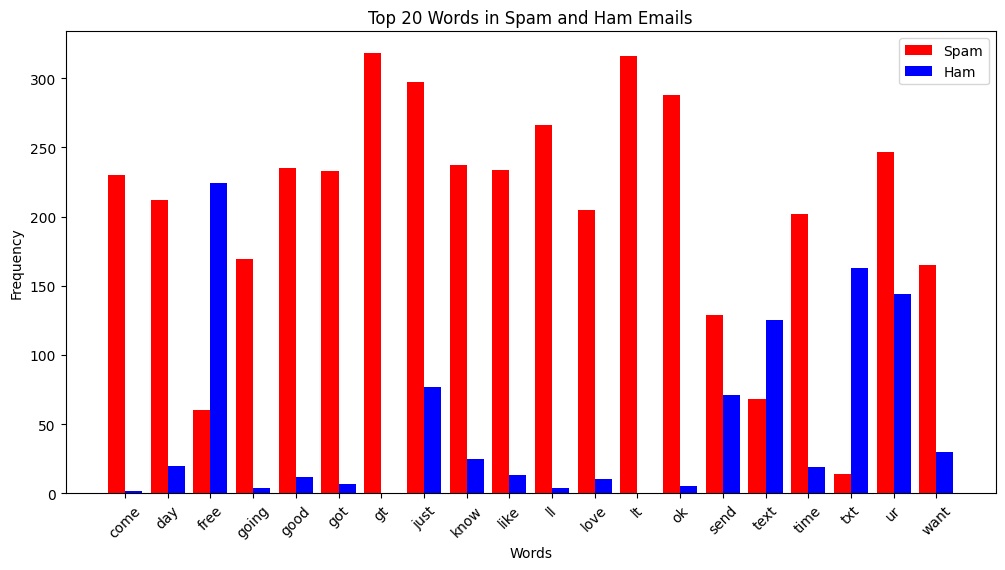

In [ ]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=20, stop_words='english')
X_counts = vectorizer.fit_transform(df['Message'])

spam_df = df[df['Category'] == "ham"]
ham_df = df[df['Category'] == "spam"]

spam_counts = vectorizer.transform(spam_df['Message']).toarray().sum(axis=0)
ham_counts = vectorizer.transform(ham_df['Message']).toarray().sum(axis=0)

words = vectorizer.get_feature_names_out()
x = np.arange(len(words))

plt.figure(figsize=(12, 6))
plt.bar(x - 0.2, spam_counts, width=0.4, label='Spam', color='orange')
plt.bar(x + 0.2, ham_counts, width=0.4, label='Ham', color='blue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 Words in Spam and Ham Emails')
plt.xticks(ticks=x, labels=words, rotation=45)
plt.legend()
plt.show()

# Data augmentation

Expand Contraction

In [ ]:
import contractions

def expand_contractions(text):
    expanded_text = contractions.fix(text)
    
    return expanded_text

In [ ]:
text = "I can't believe it's already September. He doesn't like it."

print("Original Text:", text)
print("Expanded Text:", expand_contractions(text))

Original Text: I can't believe it's already September. He doesn't like it.
Expanded Text: I cannot believe it is already September. He does not like it.


In [ ]:
df["Message, expanded"] = list(map(expand_contractions, df["Message"]))
df.to_csv("/kaggle/working/spam_enriched.csv", index=False)

## Sentence Shuffling

Sentence Shuffling involves shuffling the order of sentences within a text or paragraph. The goal is to provide the model with slightly different versions of the original text to improve its robustness. However, shuffling should be applied carefully to maintain the overall coherence of the text, especially for tasks like language modeling or text classification.

In [ ]:
import spacy
import random

nlp = spacy.load('en_core_web_lg')

def sentence_shuffling(text):
    doc = nlp(text)
    sentences = [sent.text for sent in doc.sents]
    
    random.shuffle(sentences)
    
    shuffled_text = ' '.join(sentences)
    
    return shuffled_text

In [ ]:
df["Message, sent_shuflling"] = list(map(sentence_shuffling, df["Message"]))
df.to_csv("/kaggle/working/spam_enriched.csv", index=False)


In [ ]:
!kaggle datasets download -d swayamsinghal/slang-txt

Dataset URL: https://www.kaggle.com/datasets/swayamsinghal/slang-txt
License(s): CC-BY-SA-3.0
  0%|                                               | 0.00/2.46k [00:00<?, ?B/s]
100%|██████████████████████████████████████| 2.46k/2.46k [00:00<00:00, 8.63MB/s]


In [ ]:
import csv

filename = '/kaggle/input/slang-txt/Slang Text.csv'

slangs = {}
with open(filename,'r') as data:
   for line in csv.reader(data):
      slangs[line[0]] = line[1]

slangs

{'Abbreviation': 'Full Form',
 'abt': 'about',
 'abt2': 'about to',
 'acc': 'actually',
 'add': 'address',
 'afaik': 'as far as i know',
 'afk': 'away from keyboard',
 'aka': 'also known as',
 'asap': 'as soon as possible',
 'asf': 'as f***',
 'asl': 'age, sex, location',
 'atm': 'at the moment',
 'b': 'bisexual / babe',
 'b4': 'before',
 'based': 'used when agreeing with something; or recognising someone is being themselves',
 'bc': 'because',
 'bet': 'okay; affirming something',
 'bday': 'birthday',
 'blates': 'obviously',
 'bf': 'boyfriend/best friend',
 'bf4l or bffl': 'best friends for life',
 'bff': 'best friends forever',
 'boyf': 'boyfriend',
 'brb': 'be right back',
 'btw': 'by the way',
 'cap': 'lie',
 'cba': "can't be bothered",
 'cmb': 'call me back',
 'cmon': 'come on',
 'ctn': "can't talk now",
 'cu': 'see you',
 'cua': 'see you around',
 'cul': 'see you later',
 'cya': 'see ya',
 'da f/dafuq?': 'what the f***?',
 'diss': 'disrespect',
 'dkdc': "don't know, don't care",
 

In [ ]:
import re

def replace_slang(text, slang_dict):
    pattern = re.compile(r'\b(' + '|'.join(re.escape(key) for key in slang_dict.keys()) + r')\b')
    
    formal_text = pattern.sub(lambda x: slang_dict[x.group()], str.lower(text))
    
    return formal_text

In [ ]:
informal_text = "I'm abt2 going cuz it's not too cold. Asap"

formal_text = replace_slang(informal_text, slangs)

print("Original Text:", informal_text)
print("After Slang Replacement:", formal_text)

Original Text: I'm abt2 going cuz it's not too cold. Asap
After Slang Replacement: i'male about to going cuz it's not too cold. as soon as possible


In [ ]:
from itertools import repeat

df["Message, slang_replacment"] = list(map(replace_slang, df["Message"], repeat(slangs)))
df.to_csv(fname_out, index=False)

### Synonym Replacement with spacy


In [ ]:
import spacy
import nltk
from nltk.corpus import wordnet as wn

nltk.download('punkt')

!unzip /usr/share/nltk_data/corpora/punkt.zip -d /usr/share/nltk_data/corpora/

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/co

In [ ]:
nlp = spacy.load('en_core_web_lg')

def get_synonyms(word):
    synonyms = set()
    for syn in wn.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name())
    synonyms.discard(word)  
    return list(synonyms)

def replace_synonyms(text):
    doc = nlp(text)
    new_text = []
    for token in doc:
        synonyms = get_synonyms(token.text)
        if synonyms:
            new_word = synonyms[np.random.randint(0, len(synonyms))]
            new_text.append(new_word)
        else:
            new_text.append(token.text)
    return ' '.join(new_text)

def process_samples(samples):
    return [replace_synonyms(sample) for sample in samples]

samples = [
    "I love programming in Python.",
    "Natural language processing is fascinating.",
]

new_samples = process_samples(samples)

for original, new in zip(samples, new_samples):
    print(f"Original: {original}")
    print(f"Modified: {new}")
    print()

Original: I love programming in Python.
Modified: atomic_number_53 lovemaking programing In python .

Original: Natural language processing is fascinating.
Modified: rude spoken_communication swear_out constitute captivating .



It creates something ugly/ununderstandable, let's improve it by replacing only nouns, verbs, adjectives, and adverbs.  
And let's add spacy similarity to find the best similar synonym from the nltk wordnet corpus.

In [ ]:
nlp = spacy.load('en_core_web_lg')

def get_wordnet_pos(spacy_pos):
    """Convert spaCy POS tags to WordNet POS tags."""
    if spacy_pos == 'NOUN':
        return wn.NOUN
    elif spacy_pos == 'VERB':
        return wn.VERB
    elif spacy_pos == 'ADJ':
        return wn.ADJ
    elif spacy_pos == 'ADV':
        return wn.ADV
    else:
        return None

def get_synonyms_nltk(word):
    synonyms = set()
    wn_pos = get_wordnet_pos(word.pos_)
    if wn_pos:
        for syn in wn.synsets(word.text, pos=wn_pos):
            for lemma in syn.lemmas():
                synonyms.add(lemma.name())
    synonyms.discard(word.text)
    
    return list(synonyms)

def get_best_synonym(token):
    synonyms = get_synonyms_nltk(token)
    
    if not synonyms:
        return token.text
    
    synonym_docs = [nlp(syn) for syn in synonyms]
    
    similarity_scores = [token.similarity(syn_doc) for syn_doc in synonym_docs]
     
    best_synonym = synonyms[similarity_scores.index(max(similarity_scores))]

    return best_synonym

def replace_synonyms_in_sentence(text):
    doc = nlp(text)
    new_text = text
    
    for token in doc:
        if token.pos_ in ('NOUN', 'VERB', 'ADJ', 'ADV'):
            new_word = get_best_synonym(token)
            new_text = new_text.replace(token.text, new_word)
        else:
            pass
    
    return new_text

In [ ]:
def debug_replace_synonyms_in_sentence(samples):
        
    new_samples = []

    for sample in samples:
        print(f"sample: {sample}")
        new_sample = replace_synonyms_in_sentence(sample)
        print(f"new_sample: {new_sample} \n")
        new_samples += [new_sample]
    
    return new_samples

samples = [
    "I love programming in Python.",
    "Natural language processing is fascinating.",
]

# Process the list of samples
new_samples = debug_replace_synonyms_in_sentence(samples)

sample: I love programming in Python.
new_sample: I enjoy program in Python. 

sample: Natural language processing is fascinating.
new_sample: natural terminology processing is captivating. 



/tmp/ipykernel_35/2163421125.py:51: UserWarning: [W008] Evaluating Token.similarity based on empty vectors.
  similarity_scores = [token.similarity(syn_doc) for syn_doc in synonym_docs]


Not perfect. But much much better! Let's use it to create additional samples in our original dataset.

Next cell takes time (~1 hour on standard kaggle 3GiB RAM CPU) since we have more than 5500 samples and many many words inside.

In [ ]:
df["Message, synonymized"] = list(map(replace_synonyms_in_sentence, df["Message"]))
df.to_csv("/kaggle/working/spam_enriched.csv", index=False)

/tmp/ipykernel_35/2163421125.py:51: UserWarning: [W008] Evaluating Token.similarity based on empty vectors.
  similarity_scores = [token.similarity(syn_doc) for syn_doc in synonym_docs]


In [ ]:
import random

def get_synonyms_spacy(word):
    synonyms = []
    for syn in word.vocab.vectors.most_similar(word.vector.reshape(1, word.vector.shape[0]), n=10)[0][0]:
        synonym = nlp.vocab[syn].text
        if synonym != word.text:  # Avoid the original word
            synonyms.append(synonym)
    return synonyms

def random_insertion(text, n=1):
    doc = nlp(text)
    
    non_stop_words = [token.text for token in doc if not token.is_stop and token.pos_ not in ['PUNCT', 'SPACE']]
    
    if len(non_stop_words) == 0:  # If no valid words to insert
        return text
    
    new_sentence = text.split()
    
    for _ in range(n):
        random_word = random.choice(non_stop_words)
        
        token = nlp(random_word)[0]
        synonyms = get_synonyms_spacy(token)
        
        if synonyms:
            synonym = random.choice(synonyms)
            insert_position = random.randint(0, len(new_sentence))
            new_sentence.insert(insert_position, synonym)
    
    return ' '.join(new_sentence)

In [ ]:
text = "The quick brown fox jumps over the lazy dog."
augmented_text = random_insertion(text, n=2)
print("Original:", text)
print("Augmented:", augmented_text)

In [ ]:
# takes an ~2h on standard kaggle CPU with 3GiB RAM
df["Message, rand_inserted"] = list(map(random_insertion, df["Message"]))
df.to_csv("/kaggle/working/spam_enriched.csv", index=False)
# 81m37s on hp laptop

### Random deletion

Randomly delete some words within sentences.

In [ ]:
import random

# Function to randomly delete a word
def delete_random_word(raw_text, prob=0.2):
    # Split input text by space
    words = raw_text.split()
    # Calculate number of words to delete from text
    n_words_to_delete = int(len(words) * prob)

    # Proceed with deletation
    for i in range(n_words_to_delete):
        word_ind_to_del = random.randint(0, len(words)-1)
        del words[word_ind_to_del]
    
    return " ".join(words)

In [ ]:
# Example usage
text = "The quick brown fox jumps over the lazy dog."
text_updated = delete_random_word(text, prob=0.3)
print("Original:", text)
print("Noisy:", text_updated)

In [ ]:
df["Message, rand_deleted"] = list(map(delete_random_word, df["Message"]))
df.to_csv("/kaggle/working/spam_enriched.csv", index=False)
# 0.1s on hp laptop

### Random Swap

Two words from a sentence are randomly selected and their positions are swapped

In [ ]:
def random_swap(text, n=1):
    """Split the sentence into words (punctuation marks here belong 
        to words, if you want to treat them separately it is possible
        by using regular expression or nltk/spacy/etc lib solution)
    """
    words = text.split()
    
    # Perform n swaps
    for _ in range(n):
        # Ensure there are at least two words to swap
        if len(words) < 2:
            return text
        
        # Randomly select two different indices to swap
        idx1, idx2 = random.sample(range(len(words)), 2)
        
        # Swap the words at the selected indices
        words[idx1], words[idx2] = words[idx2], words[idx1]
    
    # Join the words back into a sentence
    return ' '.join(words)

In [ ]:
# Example usage
text = "The quick brown fox jumps over the lazy dog."
augmented_text = random_swap(text, n=2)
print("Original:", text)
print("Augmented:", augmented_text)

In [ ]:
# Run on email dataset
df["Message, rand_swap"] = list(map(random_swap, df["Message"]))
df.to_csv("/kaggle/working/spam_enriched.csv", index=False)
# 0.1s on hp laptop

## Paraphrasing BART

Sentence rephrasing using BART model from HuggingFace.

In [ ]:
from transformers import pipeline
import torch

# Choose the model from HyggingFace
model = "facebook/bart-large-cnn"

# Check if GPU is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load the paraphrase model (BART or T5 are popular for paraphrasing)
paraphrase_pipeline = pipeline("text2text-generation", 
                               model=model, 
                               device=device,
                               clean_up_tokenization_spaces = True)

def paraphrase_text(doc):
    """
    Paraphrase the given text and return multiple variations.
    
    Args:
        doc (str): Input text to paraphrase.
    
    Returns:
        list: A list of paraphrased docs.
    """
    # Generate paraphrased versions
    paraphrased = paraphrase_pipeline(doc, do_sample=True)
    #print(f'pipeline output: {paraphrased[0]["generated_text"]}')
   
    return paraphrased[0]["generated_text"]


In [ ]:
# Example sentence
sentence = "Data augmentation helps in improving the performance of machine learning models. \
For more information check HuggingFace."

# Get paraphrased sentences
paraphrased_sentences = paraphrase_text(sentence)
print(f"Paraphrased: {paraphrased_sentences}")

In [ ]:
# Process email dataset in batches 

# Batch size
batch_size = 500
# Initiate empty paraphrased message
df["Message, paraphrased"] = ''

# Loop through the list in batches
for i in range(0, len(df), batch_size):
    paraphrased = paraphrase_pipeline(list(df.loc[i:i+batch_size-1, "Message"]), do_sample=True)
    df.loc[i:i+batch_size-1, "Message, paraphrased"] = list([d["generated_text"] for d in paraphrased])

# Save batch results
df.to_csv("/kaggle/working/spam_enriched.csv", index=False)

In [ ]:
import gc

# Remove pipeline and free CPU/GPU memory
del paraphrase_pipeline
gc.collect()
if device == 'cuda': torch.cuda.empty_cache() 


## Back Translation

models: `Helsinki-NLP/opus-mt-en-uk` and `Helsinki-NLP/opus-mt-uk-en`

In [ ]:
from transformers import pipeline
# Define device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Define pipelines out of the method so in case it will be used in the look it will not load every time
translator_en_uk = pipeline("translation_en_to_uk", 
                            model="Helsinki-NLP/opus-mt-en-uk", 
                            clean_up_tokenization_spaces=True,
                            device=device)
translator_uk_en = pipeline("translation_uk_to_en",
                            model="Helsinki-NLP/opus-mt-uk-en",
                            clean_up_tokenization_spaces=True,
                            device=device)

def generate_back_translations(texts):
    """
    Tranlate English text into Ukrainian and then back into English.
    
    Args:
        doc (str): Input text for back translation.
    
    Returns:
        uk_transl, en_transl (tuple): A tuple with Ukrainian and back translated English text.
    """
    # Tranlate English text into Ukrainian
    uk_translations = translator_en_uk(texts)
    uk_translations_list = [d['translation_text'] for d in uk_translations]
    # Translate Ukrainian text back into English
    en_back_transl = translator_uk_en(uk_translations_list)
    en_back_transl_list = [d['translation_text'] for d in en_back_transl]

    return uk_translations_list, en_back_transl_list


In [ ]:
# Example sentence
text = "The quick brown fox jumps over the lazy dog."
uk_translation, back_translated = generate_back_translations(text)

print(f"Original text in English: {text}")
print(f"Ukrainian translation: {uk_translation[0]}")
print(f"Back translated text in English: {back_translated[0]}")

In [ ]:
# Run on email dataset
uk_translations, df["Message, back_translated"] = generate_back_translations(list(df["Message"]))
df.to_csv("/kaggle/working/spam_enriched.csv", index=False)

# Remove pipeline and free CPU/GPU memory
del translator_en_uk, translator_uk_en
gc.collect()
if device == 'cuda': torch.cuda.empty_cache() 

## Text Generation using Language Models

Text generation in the context of Natural Language Processing (NLP) data augmentation involves creating new text samples based on existing data. It is particularly useful when there is a limited amount of labeled data available for training machine learning models. By generating synthetic data, models can be trained on a more diverse set of inputs, which can improve their generalization ability.

In [ ]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load pre-trained GPT-2 model and tokenizer
model_name = 'gpt2-large'  # You can use 'gpt2-medium', 'gpt2-large', etc.
model = GPT2LMHeadModel.from_pretrained(model_name)
tokenizer = GPT2Tokenizer.from_pretrained(model_name, device=device, clean_up_tokenization_spaces=True)

# Set the model in evaluation mode (for inference)
model.eval()

def generate_text_using_llm(start_text, max_new_tokens):

    # Tokenize the input text and create attention mask
    input_ids = tokenizer.encode(start_text, return_tensors='pt')
    attention_mask = torch.ones(input_ids.shape, dtype=torch.long)

    # Generate text (specify the maximum length for the generated text)
    output = model.generate(
        input_ids, 
        attention_mask=attention_mask,  # Pass attention mask explicitly to avoid warning
        max_new_tokens=max_new_tokens, 
        no_repeat_ngram_size=2,
        pad_token_id=tokenizer.eos_token_id,  # Ensure padding is handled correctly
    )
    
    # Decode and return generated text
    for i, generated_sequence in enumerate(output):
        generated_text = tokenizer.decode(generated_sequence, skip_special_tokens=True)
 
    return generated_text

In [ ]:
# Text prompt (the input for the model)
input_text = "The future of AI is"
max_new_tokens = 50

# Decode and print the generated text
generated_text = generate_text_using_llm(input_text, max_new_tokens)
print(f"Generated Text: {generated_text}\n")

In [ ]:
# Proceed with email dataset
number_of_input_words = 7
df["Message, generated"] = ""

# Loop to generate text by text
for ind, email in enumerate(df['Message']):
    
    # split email by words by space character
    words = email.split() 
    
    # define first words 
    input_text = " ".join(words[:number_of_input_words]) 
    
    # define max number of tokens to generate
    max_new_tokens = random.randint(len(words),len(words)+10) 

    # Generate text 
    df.loc[ind, "Message, generated"] = generate_text_using_llm(input_text, max_new_tokens)
    #print(f"{max_new_tokens}: {input_text}")
    #print(f"Generated: {df.loc[ind, "Message, generated"]}")

# Save the results
df.to_csv("/kaggle/working/spam_enriched.csv", index=False)

In [ ]:
# Remove pipeline and free CPU/GPU memory
del model, tokenizer
gc.collect()
if device == 'cuda': torch.cuda.empty_cache() 

# Classifiers

Now, let's create two ML models that will learn and be able to predict whether the message is spam or ham.

Let's start with the origin dataset without additional augmented data.

## Naive Bayes classifier

I choose MultinomialNB instead of ComplementNB here since it shows better results. Try it yourself, just comment on one model and uncomment another within Step 5 in the cell below.

Multinomial Naive Bayes (MultinomialNB)  
It implements the naive Bayes algorithm for multinomially distributed data, and is one of the two classic naive Bayes variants used in text classification (where the data are typically represented as word vector counts, although tf-idf vectors are also known to work well in practice). 

Complement Naive Bayes (ComplementNB)  
**Designed for imbalanced data:** ComplementNB was specifically created to address some of the weaknesses of MultinomialNB when dealing with imbalanced data. It focuses on the complement of each class, helping it perform better on minority classes.  
**How it works:** Unlike MultinomialNB, which estimates the likelihood of each class, ComplementNB estimates the likelihood of not being in the class, which helps mitigate the dominance of the majority class.

More info at scikit-learn doc [link](https://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes).

In [ ]:
# Import necessary libraries
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Split dataset into features (X) and labels (y)
X = df['Message'].values     # This is the text of the emails
y = df['Category']    # This is the spam/ham label (e.g., 'spam' or 'ham')

# # Encode labels
# y_encoded = LabelEncoder().fit_transform(y)

# Step 2: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# print(f'lenght of X_train: {len(X_train)};\nlenght of X_test: {len(X_test)};')

# Step 3: Create the CountVectorizer and fit it on the training data only
# Transform the training text data into numeric feature vectors removing stop_words before
vectorizer = CountVectorizer(stop_words='english')
X_train_transformed = vectorizer.fit_transform(X_train)

# Step 4: Transform the test data using the same vectorizer (without fitting again)
# This ensures that only the words learned from the training set are used in the test set
X_test_transformed = vectorizer.transform(X_test)

# Step 5: Train the Naive Bayes model
model = MultinomialNB(fit_prior=True) # fit_prior to handle imbalance
# model = ComplementNB()
model.fit(X_train_transformed, y_train)

# Step 6: Make predictions on the test set
y_pred = model.predict(X_test_transformed)

# Step 7: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Step 8: Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure()
sns.heatmap(cm, 
            annot=True,
            fmt='g', 
            xticklabels=['Ham','Spam'],
            yticklabels=['Ham','Spam'])
plt.title('Confusion Matrix', fontsize=17, pad=20)
plt.gca().xaxis.set_label_position('top') 
plt.xlabel('Prediction', fontsize=13)
plt.ylabel('Actual', fontsize=13)
plt.gca().xaxis.tick_top()
plt.gca().figure.subplots_adjust(bottom=0.2)
plt.show()

## Support Vector Machine (SVM) classifier

We use the class_weight='balanced' since our dataset is imbalanced.  
We use a linear kernel for text classification, reasons:
- In text classification, the data often lies in high-dimensional sparse spaces (many features but most of them are zeros, e.g., from TF-IDF or CountVectorizer representations). A linear kernel can effectively separate classes in this space.
- The linear kernel is computationally much faster than non-linear kernels, especially when working with high-dimensional text data.
- In text classification problems like spam detection, the relationship between features (words) and the target (spam/ham) is often linear, which is why a linear kernel performs well.

In [ ]:
# Import necessary libraries
from sklearn.svm import SVC

# Step 1: Split dataset into features (X) and labels (y)
X = df['Message']     # This is the text of the emails
y = df['Category']    # This is the spam/ham label (e.g., 'spam' or 'ham')

# Step 2: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Create the CountVectorizer and fit it on the training data only
# Transform the training text data into numeric feature vectors removing stop_words before
vectorizer = CountVectorizer(stop_words='english')
X_train_transformed = vectorizer.fit_transform(X_train)

# Step 4: Transform the test data using the same vectorizer (without fitting again)
X_test_transformed = vectorizer.transform(X_test)

# Step 5: Train the Support Vector Machine (SVM) model
model = SVC(kernel='linear', class_weight='balanced')  
model.fit(X_train_transformed, y_train)

# Step 6: Make predictions on the test set
y_pred = model.predict(X_test_transformed)

# Step 7: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Step 8: Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure()
sns.heatmap(cm, 
            annot=True,
            fmt='g', 
            xticklabels=['Ham','Spam'],
            yticklabels=['Ham','Spam'])
plt.title('Confusion Matrix', fontsize=17, pad=20)
plt.gca().xaxis.set_label_position('top') 
plt.xlabel('Prediction', fontsize=13)
plt.ylabel('Actual', fontsize=13)
plt.gca().xaxis.tick_top()
plt.gca().figure.subplots_adjust(bottom=0.2)
plt.show()